In [1]:
import cv2
import numpy as np
import os
from random import shuffle
from tqdm import tqdm

TRAIN_DIR = 'E:\\Courses\\youtube\\DeepLearning_with_Tensorflow\\CNN\\Dogs vs. Cats Redux\\train'
TEST_DIR = 'E:\\Courses\\youtube\\DeepLearning_with_Tensorflow\\CNN\\Dogs vs. Cats Redux\\test'
IMAGE_SIZE = 50
LR = 1e-3

MODEL_NAME = 'dogsvscats-{}-{}.model'.format(LR, '6conv-basic')

In [2]:
def label_img(img):
    word_label = img.split('.')[-3]
    return [1,0] if word_label=='cat' else [0,1] if word_label=='dog' else None    

In [3]:
def create_train_data():
    training_data = []
    for img in tqdm(os.listdir(TRAIN_DIR)):
        label = label_img(img)
        path = os.path.join(TRAIN_DIR, img)
        img = cv2.resize(cv2.imread(path, cv2.IMREAD_GRAYSCALE), (IMAGE_SIZE, IMAGE_SIZE))
        training_data.append([np.array(img), np.array(label)])
    shuffle(training_data) 
    np.save('train_data.npy', training_data)
    return training_data    

In [13]:
def process_test_data():
    testing_data = []
    for img in tqdm(os.listdir(TEST_DIR)):
        path = os.path.join(TEST_DIR,img)
        img_num = img.split('.')[0]
        img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (IMAGE_SIZE,IMAGE_SIZE))
        testing_data.append([np.array(img), img_num])
        
    shuffle(testing_data)
    np.save('test_data.npy', testing_data)
    return testing_data

In [5]:
# train_data = create_train_data()
# if there is already training data:
train_data = np.load('train_data.npy')
not_a_tensor = np.array([train_data[0][0]])
tensor = np.array([train_data[0][0]]).reshape(-1,IMAGE_SIZE,IMAGE_SIZE,1) 
print("Shape of not_a_tensor = ", not_a_tensor.shape) 
print("Shape of tensor = ", tensor.shape)

Shape of not_a_tensor =  (1, 50, 50)
Shape of tensor =  (1, 50, 50, 1)


In [6]:
import tflearn
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.estimator import regression

import tensorflow as tf
tf.reset_default_graph()

convnet = input_data(shape=[None, IMAGE_SIZE, IMAGE_SIZE, 1], name='input')

convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 128, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = fully_connected(convnet, 1024, activation='relu')
convnet = dropout(convnet, 0.8)

convnet = fully_connected(convnet, 2, activation='softmax')
convnet = regression(convnet, optimizer='adam', learning_rate=LR, loss='categorical_crossentropy', name='targets')

model = tflearn.DNN(convnet, tensorboard_dir='log')

E:\Anaconda3\lib\site-packages\h5py\__init__.py:72: UserWarning: h5py is running against HDF5 1.10.2 when it was built against 1.10.3, this may cause problems
  '{0}.{1}.{2}'.format(*version.hdf5_built_version_tuple)


curses is not supported on this machine (please install/reinstall curses for an optimal experience)
Instructions for updating:
Use tf.initializers.variance_scaling instead with distribution=uniform to get equivalent behavior.
Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [7]:
if os.path.exists('{}.meta'.format(MODEL_NAME)):
    model.load(MODEL_NAME)
    print('model loaded!')

INFO:tensorflow:Restoring parameters from E:\Courses\youtube\DeepLearning_with_Tensorflow\CNN\Dogs vs. Cats Redux\dogsvscats-0.001-6conv-basic.model
model loaded!


In [8]:
train = train_data[:-500]
test = train_data[-500:]

In [9]:
X = np.array([i[0] for i in train]).reshape(-1, IMAGE_SIZE, IMAGE_SIZE, 1)
Y = [i[1] for i in train]

test_x = np.array([i[0] for i in test]).reshape(-1, IMAGE_SIZE, IMAGE_SIZE, 1)
test_y = [i[1] for i in train]

In [10]:
model.fit({'input': X}, {'targets': Y}, n_epoch=5, validation_set=({'input': test_x}, {'targets': test_y}), 
    snapshot_step=500, show_metric=True, run_id=MODEL_NAME)

Training Step: 7659  | total loss: 0.21081 | time: 8.276s
| Adam | epoch: 005 | loss: 0.21081 - acc: 0.9140 -- iter: 24448/24500
Training Step: 7660  | total loss: 0.20361 | time: 9.304s
| Adam | epoch: 005 | loss: 0.20361 - acc: 0.9179 | val_loss: 2.54946 - val_acc: 0.4960 -- iter: 24500/24500
--


In [11]:
model.save(MODEL_NAME)

INFO:tensorflow:E:\Courses\youtube\DeepLearning_with_Tensorflow\CNN\Dogs vs. Cats Redux\dogsvscats-0.001-6conv-basic.model is not in all_model_checkpoint_paths. Manually adding it.


In [16]:
import matplotlib.pyplot as plt

# if you don't have the file:
# test_data = process_test_data()
# if file already exists:
test_data = np.load('test_data.npy')

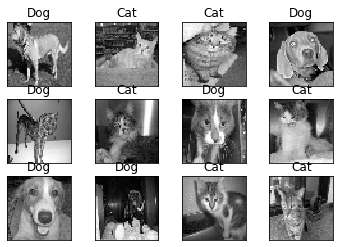

In [18]:
fig=plt.figure()

for num,data in enumerate(test_data[:12]):
    # cat: [1,0]
    # dog: [0,1]
    
    img_num = data[1]
    img_data = data[0]
    
    y = fig.add_subplot(3,4,num+1)
    orig = img_data
    data = img_data.reshape(IMAGE_SIZE,IMAGE_SIZE,1)
    #model_out = model.predict([data])[0]
    model_out = model.predict([data])[0]
    
    if np.argmax(model_out) == 1: str_label='Dog'
    else: str_label='Cat'
        
    y.imshow(orig,cmap='gray')
    plt.title(str_label)
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)
plt.show()

In [20]:
with open('submission_file.csv','w') as f:
    f.write('id,label\n')
            
with open('submission_file.csv','a') as f:
    for data in tqdm(test_data):
        img_num = data[1]
        img_data = data[0]
        orig = img_data
        data = img_data.reshape(IMAGE_SIZE,IMAGE_SIZE,1)
        model_out = model.predict([data])[0]
        f.write('{},{}\n'.format(img_num,model_out[1]))

100%|███████████████████████████████████████████████████████████████████████████| 12500/12500 [00:30<00:00, 408.43it/s]
